In [1]:
import os
import sys
import torch
from torchinfo import summary
from torchvision.transforms import v2
from torch.utils.data import DataLoader

module_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.dirname(module_dir))


from modules.data import PhoneDataset
from modules.models import ConvolutionalLocator
from modules.training import EarlyStopping, ModelTrainer
from modules.transforms import (
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomTranslation
)
from modules.utilities import (
    get_data,
    visualize_augmentations,
    train_test_split
)

/home/nicolas/anaconda3/envs/ml-python311/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/nicolas/anaconda3/envs/ml-python311/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. 

In [2]:
folder = os.path.join('..', 'find_phone_data')
seed = 0
test_size = 0.1
batch_size = 128
patience = 5
min_delta = 0.0
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam
early_stopping = EarlyStopping(20)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
epochs = 50
lr = 1e-2
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
image_paths, locations = get_data(folder)
print(image_paths[0])
print(locations[os.path.basename(image_paths[0])])

../find_phone_data/51.jpg
(0.2388, 0.6012)


In [4]:
train_image_paths, test_image_paths, train_locations, test_locations = train_test_split(
    image_paths, locations, test_size, seed
)
print(train_image_paths[0])
print(train_locations[os.path.basename(train_image_paths[0])])

../find_phone_data/27.jpg
(0.6245, 0.3067)


In [5]:
aware_transforms = v2.Compose([
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomTranslation(),
])

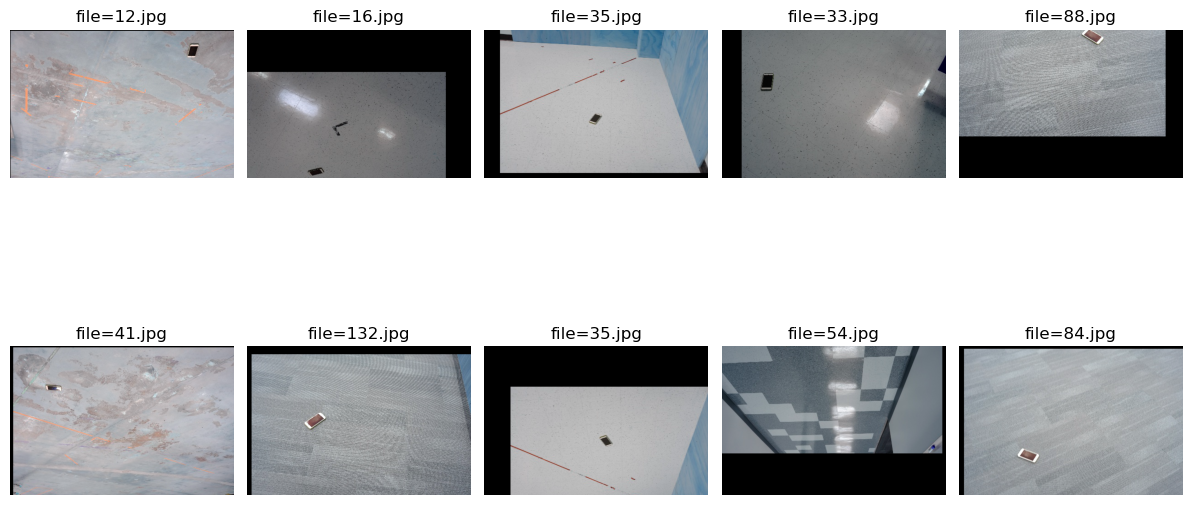

In [6]:
train_dataset = PhoneDataset(
    train_image_paths, train_locations,
    aware_transforms,
)

test_dataset = PhoneDataset(test_image_paths, test_locations)
visualize_augmentations(train_dataset, train_locations, random_img=True)

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([116, 3, 326, 490]) torch.float32
Shape of y: torch.Size([116, 2]) torch.float32


In [8]:
model_trainer = ModelTrainer(
    train_dataloader,
    test_dataloader,
    loss_fn,
    optimizer,
    early_stopping,
    scheduler,
    device
)

In [15]:
c_in = 3
h_in, w_in = 326, 490

model = torch.hub.load(
    'pytorch/vision:v0.10.0',
    'alexnet',
    weights='AlexNet_Weights.DEFAULT'
)

summary(
    model=model,
    input_size=(batch_size, c_in, h_in, w_in),
    col_names=["input_size", "output_size", "num_params"],
    col_width=20,
    row_settings=["var_names"]
)

Using cache found in /home/nicolas/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type (var_name))                  Input Shape          Output Shape         Param #
AlexNet (AlexNet)                        [128, 3, 326, 490]   [128, 1000]          --
├─Sequential (features)                  [128, 3, 326, 490]   [128, 256, 9, 14]    --
│    └─Conv2d (0)                        [128, 3, 326, 490]   [128, 64, 80, 121]   23,296
│    └─ReLU (1)                          [128, 64, 80, 121]   [128, 64, 80, 121]   --
│    └─MaxPool2d (2)                     [128, 64, 80, 121]   [128, 64, 39, 60]    --
│    └─Conv2d (3)                        [128, 64, 39, 60]    [128, 192, 39, 60]   307,392
│    └─ReLU (4)                          [128, 192, 39, 60]   [128, 192, 39, 60]   --
│    └─MaxPool2d (5)                     [128, 192, 39, 60]   [128, 192, 19, 29]   --
│    └─Conv2d (6)                        [128, 192, 19, 29]   [128, 384, 19, 29]   663,936
│    └─ReLU (7)                          [128, 384, 19, 29]   [128, 384, 19, 29]   --
│    └─Conv2d (8)                  

In [17]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
import numpy as np
a = np.array([1, 2, 3])
np.array([a]).shape

(1, 3)

In [10]:
for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(in_features, 2)

In [11]:
model_trainer = ModelTrainer(
    train_dataloader,
    test_dataloader,
    loss_fn,
    optimizer,
    early_stopping,
    scheduler,
    device
)

model_trainer(epochs, model, lr)

Epoch 1
-------------------------------
loss: 1.153044  [  116/  116]
 Cummulative loss: 1.153044
Test Error: 
 Accuracy: 0.0%, Avg loss: 89.910569 

Epoch 2
-------------------------------
loss: 108.849190  [  116/  116]
 Cummulative loss: 108.849190
Test Error: 
 Accuracy: 0.0%, Avg loss: 6.531769 

Epoch 3
-------------------------------
loss: 8.460032  [  116/  116]
 Cummulative loss: 8.460032
Test Error: 
 Accuracy: 0.0%, Avg loss: 19.778405 

Epoch 4
-------------------------------
loss: 26.055092  [  116/  116]
 Cummulative loss: 26.055092
Test Error: 
 Accuracy: 0.0%, Avg loss: 48.834928 

Epoch 5
-------------------------------
loss: 61.507576  [  116/  116]
 Cummulative loss: 61.507576
Test Error: 
 Accuracy: 0.0%, Avg loss: 32.881911 

Epoch 6
-------------------------------
loss: 42.315918  [  116/  116]
 Cummulative loss: 42.315918
Test Error: 
 Accuracy: 0.0%, Avg loss: 6.513701 

Epoch 7
-------------------------------
loss: 8.694984  [  116/  116]
 Cummulative loss: 8.6

In [12]:
for param in model.parameters():
    param.grad_requires = True

model_trainer(epochs, model, lr)

Epoch 1
-------------------------------
loss: 0.513215  [  116/  116]
 Cummulative loss: 0.513215
Test Error: 
 Accuracy: 0.0%, Avg loss: 95.644869 

Epoch 2
-------------------------------
loss: 124.566170  [  116/  116]
 Cummulative loss: 124.566170
Test Error: 
 Accuracy: 0.0%, Avg loss: 6.430432 

Epoch 3
-------------------------------
loss: 7.863173  [  116/  116]
 Cummulative loss: 7.863173
Test Error: 
 Accuracy: 0.0%, Avg loss: 20.600335 

Epoch 4
-------------------------------
loss: 25.722002  [  116/  116]
 Cummulative loss: 25.722002
Test Error: 
 Accuracy: 0.0%, Avg loss: 54.986798 

Epoch 5
-------------------------------
loss: 71.703552  [  116/  116]
 Cummulative loss: 71.703552
Test Error: 
 Accuracy: 0.0%, Avg loss: 39.773297 

Epoch 6
-------------------------------
loss: 52.079441  [  116/  116]
 Cummulative loss: 52.079441
Test Error: 
 Accuracy: 0.0%, Avg loss: 10.145759 

Epoch 7
-------------------------------
loss: 14.190544  [  116/  116]
 Cummulative loss: 1

In [13]:
model.eval()
train_size = len(train_dataloader.dataset)
train_correct = 0
for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    correct = (torch.sum((y - pred)**2, dim=-1) < 0.05)
    train_correct += correct.type(torch.float).sum().item()

test_size = len(test_dataloader.dataset)
test_correct = 0
for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    correct = (torch.sum((y - pred)**2, dim=-1) < 0.05)
    test_correct += correct.type(torch.float).sum().item()

print(f'Train set accuracy: {train_correct / train_size}')
print(f'Test set accuracy: {test_correct / test_size}')

Train set accuracy: 0.1724137931034483
Test set accuracy: 0.5384615384615384
